In [32]:
# ============================================================================
# Import Libraries
# ============================================================================
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns

In [33]:
# ============================================================================
# Helper Functions
# ============================================================================

# Print formatted step header with step number, title and optional explanation
def print_step_header(step_number, step_title, explanation=None):
    print(f"\n{'='*75}")
    print(f"# STEP {step_number}: {step_title}")
    print(f"{'='*75}")
    if explanation:
        print(f"# Explanation: {explanation}")

# Print formatted section title with separator lines
def print_section_title(title, subtitle=None):
    """
    Print a formatted section title with separator lines.

    Parameters:
    - title: Main title text (will be prefixed with '#')
    - subtitle: Optional subtitle text (will be prefixed with '#')
    """
    print(f"\n{'='*75}")
    print(f"# {title}")
    print(f"{'='*75}")
    if subtitle:
        print(f"# {subtitle}")

# Analyze field type conversion: original type, target type, and conversion reason
def type_conversion(df, field_name, target_type, conversion_reason, field_description=None):
    if field_name not in df.columns:
        print(f"   - Field '{field_name}' not found in dataset")
        return df

    # Get original type directly from DataFrame (before conversion)
    original_type = str(df[field_name].dtype)
    if field_description:
        print(f"   - Field description: {field_description}")
    print(f"   - Original type: {original_type}")
    print(f"   - Target type: {target_type}")
    print(f"   - Conversion reason: {conversion_reason}")

    # Check if conversion is needed
    if original_type == target_type or original_type == target_type.replace('64', '32'):
        print(f"   - Status: No conversion needed (already {target_type})")
        return df

    try:
        # Perform actual type conversion
        if target_type == 'datetime64[ns]':
            df[field_name] = pd.to_datetime(df[field_name], errors='coerce')
        elif target_type == 'category':
            # Convert to object type instead of category for better compatibility with statistical calculations
            df[field_name] = df[field_name].astype('object')
        elif target_type == 'bool':
            # Convert yes/no, Y/N, True/False to boolean
            if df[field_name].dtype == 'object':
                # Map common boolean representations
                bool_map = {
                    'Yes': True, 'Y': True, 'yes': True, 'y': True, 'True': True, 'true': True, 'TRUE': True,
                    'No': False, 'N': False, 'no': False, 'n': False, 'False': False, 'false': False, 'FALSE': False
                }
                df[field_name] = df[field_name].map(bool_map)
                # Fill any unmapped values with False (or handle NaN appropriately)
                # Use where method to avoid FutureWarning about downcasting
                df[field_name] = df[field_name].where(df[field_name].notna(), False)
            df[field_name] = df[field_name].astype('bool')
        elif target_type == 'float64':
            df[field_name] = pd.to_numeric(df[field_name], errors='coerce').astype('float64')
        elif target_type == 'int64':
            # Convert to numeric first (handles NaN)
            numeric_series = pd.to_numeric(df[field_name], errors='coerce')
            # Check if there are any NaN values
            if numeric_series.isna().any():
                # Use nullable integer type (Int64) to preserve NaN
                df[field_name] = numeric_series.astype('Int64')
                print(f"   - Note: Field contains missing values, using nullable integer type (Int64)")
            else:
                # No NaN values, can safely convert to int64
                df[field_name] = numeric_series.astype('int64')
        elif target_type == 'object':
            df[field_name] = df[field_name].astype('object')
        else:
            # Generic conversion
            df[field_name] = df[field_name].astype(target_type)

        new_type = str(df[field_name].dtype)
        print(f"   - Status: Converted successfully to {new_type}")

    except Exception as e:
        print(f"   - Status: Conversion failed - {str(e)}")

    return df

# Print statistical summary for a categorical column including unique values, missing values and top frequencies
def print_categorical_summary(df, col):

    unique_count = df[col].nunique()
    null_count = df[col].isnull().sum()
    null_pct = (null_count / len(df)) * 100

    print(f"\n{col}:")
    print(f"  - Unique values: {unique_count:,}")
    print(f"  - Missing values: {null_count:,} ({null_pct:.2f}%)")

    # Show top values based on cardinality
    if unique_count <= 20:
        top_n = 10
        label = "Top values"
    elif unique_count <= 100:
        top_n = 5
        label = "Top 5 values"
    else:
        top_n = 1
        label = "Most frequent"

    value_counts = df[col].value_counts().head(top_n)
    print(f"  - {label}:")
    for val, count in value_counts.items():
        pct = (count / len(df)) * 100
        print(f"    * {val}: {count:,} ({pct:.1f}%)")

    if unique_count > 100:
        print(f"  - Note: High cardinality ({unique_count:,} unique values) - consider grouping for analysis")

# Plot distribution charts (histograms, bar charts) for numeric, boolean or categorical variables
def plot_distributions(df, columns, var_type='numeric'):

    if len(columns) == 0:
        return

    n_cols = min(3, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

    # Handle different subplot configurations
    if n_rows == 1 and n_cols == 1:
        # Single subplot: axes is a single Axes object
        axes = [axes]
    elif n_rows == 1:
        # Single row: axes is a 1D array
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        # Multiple rows: axes is a 2D array
        axes = axes.flatten()

    for idx, col in enumerate(columns):
        ax = axes[idx]

        if var_type == 'numeric':
            # Histogram for numeric variables
            df[col].hist(bins=50, ax=ax, edgecolor='black')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)

        elif var_type == 'boolean':
            # Bar chart for boolean variables
            value_counts = df[col].value_counts()

            # Use different colors for True/False
            colors = ['#1f77b4' if val else '#ff7f0e' for val in value_counts.index]
            value_counts.plot(kind='bar', ax=ax, edgecolor='black', color=colors)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.tick_params(axis='x', rotation=0)
            ax.grid(True, alpha=0.3, axis='y')

            # Add percentage labels on bars
            total = len(df[col].dropna())
            for i, (val, count) in enumerate(value_counts.items()):
                pct = (count / total) * 100 if total > 0 else 0
                ax.text(i, count, f'{count:,}\n({pct:.1f}%)',
                       ha='center', va='bottom', fontsize=9)

        elif var_type == 'categorical':
            # Bar chart for categorical variables
            unique_count = df[col].nunique()

            if unique_count <= 20:
                # Show all values
                value_counts = df[col].value_counts()
            else:
                # Show top 10
                value_counts = df[col].value_counts().head(10)

            value_counts.plot(kind='bar', ax=ax, edgecolor='black')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3, axis='y')

    # Hide unused subplots
    for idx in range(len(columns), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

In [34]:
# ============================================================================
# SECTION 3: DATA UNDERSTANDING
# ============================================================================

# ============================================================================
# STEP 3.1: Collect initial data
# ============================================================================
print_step_header("3.1", "Collect initial data")

random.seed(2025)
np.random.seed(2025)

# Read the data
df = pd.read_csv('TrafficViolations.csv')

print(df.head())



# STEP 3.1: Collect initial data
                                  SeqID Date Of Stop Time Of Stop Agency  \
0  b4fedce9-1be2-41d0-b600-e2987e079ecd   11/01/2025     06:57:00    MCP   
1  89ddefe5-70f2-4b30-9d60-99ea481a505b   11/01/2025     06:38:00    MCP   
2  3b3f3ef9-b28d-4203-ab65-4b92c9e40748   11/01/2025     06:16:00    MCP   
3  a6b25057-e8a1-4d03-a607-7182574808e6   11/01/2025     06:12:00    MCP   
4  f2191d01-7f2b-4fbd-8e06-97ebd82f1056   11/01/2025     05:59:00    MCP   

                                         SubAgency  \
0  6th District, Gaithersburg / Montgomery Village   
1                           2nd District, Bethesda   
2                      3rd District, Silver Spring   
3                         5th District, Germantown   
4                         5th District, Germantown   

                                         Description  \
0  DRIVING MOTOR VEH. NOT IN ACCORDW/ EQUIP., PER...   
1  DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
2  EXCEEDING POS

In [35]:
# ============================================================================
# STEP 3.2: Describe data
# ============================================================================
print_step_header("3.2", "Describe data")

# ============================================================================
# 3.2.1. Field Type Analysis (Hardcoded)
# ============================================================================
print_step_header("3.2.0", "Field Type Analysis (Hardcoded)")

print("\nData types for all 43 fields:")

# Field 1: SeqID
print("\n1. SeqID:")
df = type_conversion(
    df, 'SeqID', 'object',
    "UUID identifier; excluded from models",
    "Unique sequence identifier for the traffic stop record"
)

# Field 2: Date Of Stop
print("\n2. Date Of Stop:")
df = type_conversion(
    df, 'Date Of Stop', 'datetime64[ns]',
    "For time-based analysis, trend analysis, seasonal pattern identification, and temporal feature engineering",
    "Date when the traffic stop occurred"
)

# Field 3: Time Of Stop
print("\n3. Time Of Stop:")
df = type_conversion(
    df, 'Time Of Stop', 'object',
    "For temporal pattern analysis, hour feature extraction, and time-of-day violation pattern identification",
    "Time when the traffic stop occurred"
)

# Field 4: Agency
print("\n4. Agency:")
df = type_conversion(
    df, 'Agency', 'object',
    "For inter-agency comparison, grouping analysis, and law enforcement efficiency assessment",
    "Law enforcement agency that conducted the stop"
)

# Field 5: SubAgency
print("\n5. SubAgency:")
df = type_conversion(
    df, 'SubAgency', 'object',
    "For sub-agency comparison, regional grouping analysis, and enforcement pattern identification",
    "Sub-agency or division that conducted the stop"
)

# Field 6: Description
print("\n6. Description:")
df = type_conversion(
    df, 'Description', 'object',
    "For violation description text analysis, keyword extraction, and violation pattern identification from text",
    "Description of the traffic violation incident"
)

# Field 7: Location
print("\n7. Location:")
df = type_conversion(
    df, 'Location', 'object',
    "For location text analysis, geocoding, address parsing, and geographic feature engineering",
    "Location where the traffic stop occurred"
)

# Field 8: Latitude
print("\n8. Latitude:")
df = type_conversion(
    df, 'Latitude', 'float64',
    "For precise geographic calculations, spatial analysis, hotspot identification, and geographic feature engineering",
    "Latitude coordinate of the stop location"
)

# Field 9: Longitude
print("\n9. Longitude:")
df = type_conversion(
    df, 'Longitude', 'float64',
    "For precise geographic calculations, spatial analysis, hotspot identification, and geographic feature engineering",
    "Longitude coordinate of the stop location"
)

# Field 10: Accident
print("\n10. Accident:")
df = type_conversion(
    df, 'Accident', 'bool',
    "For accident correlation analysis, risk factor identification, and conditional filtering",
    "Whether an accident was involved"
)

# Field 11: Belts
print("\n11. Belts:")
df = type_conversion(
    df, 'Belts', 'bool',
    "For safety measure analysis, accident severity correlation analysis, and feature engineering",
    "Whether seat belts were used"
)

# Field 12: Personal Injury
print("\n12. Personal Injury:")
df = type_conversion(
    df, 'Personal Injury', 'bool',
    "For accident severity analysis, risk assessment, and outcome prediction",
    "Whether there was personal injury"
)

# Field 13: Property Damage
print("\n13. Property Damage:")
df = type_conversion(
    df, 'Property Damage', 'bool',
    "For accident consequence analysis, loss assessment, and risk factor identification",
    "Whether there was property damage"
)

# Field 14: Fatal
print("\n14. Fatal:")
df = type_conversion(
    df, 'Fatal', 'bool',
    "For severe accident analysis, fatal factor identification, and risk assessment",
    "Whether the incident was fatal"
)

# Field 15: Commercial License
print("\n15. Commercial License:")
df = type_conversion(
    df, 'Commercial License', 'bool',
    "For driver type analysis, violation pattern identification, and feature engineering",
    "Whether the driver had a commercial license"
)

# Field 16: HAZMAT
print("\n16. HAZMAT:")
df = type_conversion(
    df, 'HAZMAT', 'bool',
    "For hazardous material transport analysis, risk assessment, and special vehicle identification",
    "Whether hazardous materials were involved"
)

# Field 17: Commercial Vehicle
print("\n17. Commercial Vehicle:")
df = type_conversion(
    df, 'Commercial Vehicle', 'bool',
    "For vehicle type analysis, commercial vehicle violation pattern identification, and feature engineering",
    "Whether the vehicle was commercial"
)

# Field 18: Alcohol
print("\n18. Alcohol:")
df = type_conversion(
    df, 'Alcohol', 'bool',
    "For DUI analysis, serious violation identification, and risk factor analysis",
    "Whether alcohol was involved"
)

# Field 19: Work Zone
print("\n19. Work Zone:")
df = type_conversion(
    df, 'Work Zone', 'bool',
    "For construction zone analysis, special area violation pattern identification, and risk assessment",
    "Whether the incident occurred in a work zone"
)

# Field 20: Search Conducted
print("\n20. Search Conducted:")
df = type_conversion(
    df, 'Search Conducted', 'bool',
    "For search behavior analysis, enforcement pattern identification, and conditional filtering",
    "Whether a search was conducted"
)

# Field 21: Search Disposition
print("\n21. Search Disposition:")
df = type_conversion(
    df, 'Search Disposition', 'object',
    "For search disposition type analysis, enforcement procedure assessment, and grouped statistics",
    "Disposition of the search conducted"
)

# Field 22: Search Outcome
print("\n22. Search Outcome:")
df = type_conversion(
    df, 'Search Outcome', 'object',
    "For search outcome analysis, search effectiveness evaluation, and pattern identification",
    "Outcome of the search conducted"
)

# Field 23: Search Reason
print("\n23. Search Reason:")
df = type_conversion(
    df, 'Search Reason', 'object',
    "For search reason analysis, enforcement reasonableness assessment, and reason categorization",
    "Reason for conducting the search"
)

# Field 24: Search Reason For Stop
print("\n24. Search Reason For Stop:")
df = type_conversion(
    df, 'Search Reason For Stop', 'object',
    "For stop reason analysis, search trigger factor identification, and correlation analysis",
    "Reason for the stop that led to search"
)

# Field 25: Search Type
print("\n25. Search Type:")
df = type_conversion(
    df, 'Search Type', 'object',
    "For search type analysis, enforcement method categorization, and pattern identification",
    "Type of search conducted"
)

# Field 26: Search Arrest Reason
print("\n26. Search Arrest Reason:")
df = type_conversion(
    df, 'Search Arrest Reason', 'object',
    "For arrest reason analysis, search-to-arrest correlation analysis, and outcome prediction",
    "Reason for arrest if search led to arrest"
)

# Field 27: State
print("\n27. State:")
df = type_conversion(
    df, 'State', 'object',
    "For geographic grouping analysis, inter-regional comparison, and geographic feature engineering",
    "US state where the stop occurred"
)

# Field 28: VehicleType
print("\n28. VehicleType:")
df = type_conversion(
    df, 'VehicleType', 'object',
    "For vehicle type analysis, violation pattern identification, and feature engineering",
    "Type of vehicle involved"
)

# Field 29: Year
print("\n29. Year:")
df = type_conversion(
    df, 'Year', 'int64',
    "For vehicle age analysis, numeric calculations, filtering, and feature engineering. Missing values (NaN) will be filled later when needed",
    "Year of the vehicle"
)

# Field 30: Make
print("\n30. Make:")
df = type_conversion(
    df, 'Make', 'object',
    "For vehicle brand analysis, inter-brand violation pattern comparison, and feature engineering",
    "Make/manufacturer of the vehicle"
)

# Field 31: Model
print("\n31. Model:")
df = type_conversion(
    df, 'Model', 'object',
    "For vehicle model analysis, specific model violation pattern identification, and feature engineering",
    "Model of the vehicle"
)

# Field 32: Color
print("\n32. Color:")
df = type_conversion(
    df, 'Color', 'object',
    "For vehicle color analysis, color-violation correlation analysis, and feature engineering",
    "Color of the vehicle"
)

# Field 33: Violation Type
print("\n33. Violation Type:")
df = type_conversion(
    df, 'Violation Type', 'object',
    "For violation type classification analysis, violation pattern identification, and target variable construction",
    "Type of traffic violation"
)

# Field 34: Charge
print("\n34. Charge:")
df = type_conversion(
    df, 'Charge', 'object',
    "For legal charge analysis, charge pattern identification, and legal text pattern matching",
    "Charge filed against the driver"
)

# Field 35: Article
print("\n35. Article:")
df = type_conversion(
    df, 'Article', 'object',
    "For legal article analysis, statute pattern identification, and legal text pattern matching",
    "Legal article or statute related to the violation"
)

# Field 36: Contributed To Accident
print("\n36. Contributed To Accident:")
df = type_conversion(
    df, 'Contributed To Accident', 'bool',
    "For violation-accident correlation analysis, causal relationship identification, and risk assessment",
    "Whether the violation contributed to an accident"
)

# Field 37: Race
print("\n37. Race:")
df = type_conversion(
    df, 'Race', 'object',
    "For demographic analysis, fairness assessment, and grouped comparison analysis",
    "Race/ethnicity of the driver"
)

# Field 38: Gender
print("\n38. Gender:")
df = type_conversion(
    df, 'Gender', 'object',
    "For gender analysis, gender-based violation pattern difference analysis, and grouped statistics",
    "Gender of the driver"
)

# Field 39: Driver City
print("\n39. Driver City:")
df = type_conversion(
    df, 'Driver City', 'object',
    "For driver residence location analysis, geographic pattern identification, and feature engineering",
    "City where the driver resides"
)

# Field 40: Driver State
print("\n40. Driver State:")
df = type_conversion(
    df, 'Driver State', 'object',
    "For driver residence state analysis, cross-state violation pattern identification, and geographic feature engineering",
    "US state where the driver resides"
)

# Field 41: DL State
print("\n41. DL State:")
df = type_conversion(
    df, 'DL State', 'object',
    "For license issuing state analysis, cross-state driving pattern identification, and feature engineering",
    "State that issued the driver's license"
)

# Field 42: Arrest Type
print("\n42. Arrest Type:")
df = type_conversion(
    df, 'Arrest Type', 'object',
    "For arrest type analysis, arrest pattern categorization, and outcome prediction",
    "Type of arrest made during the stop"
)

# Field 43: Geolocation
print("\n43. Geolocation:")
df = type_conversion(
    df, 'Geolocation', 'object',
    "For spatial analysis, geographic pattern identification, and coordinate parsing. Field may contain coordinate strings or geographic objects",
    "Geographic location information of the stop"
)

print("\n" + "="*75)
print("Field type analysis completed (43 fields analyzed)")
print("="*75)


# STEP 3.2: Describe data

# STEP 3.2.0: Field Type Analysis (Hardcoded)

Data types for all 43 fields:

1. SeqID:
   - Field description: Unique sequence identifier for the traffic stop record
   - Original type: object
   - Target type: object
   - Conversion reason: UUID identifier; excluded from models
   - Status: No conversion needed (already object)

2. Date Of Stop:
   - Field description: Date when the traffic stop occurred
   - Original type: object
   - Target type: datetime64[ns]
   - Conversion reason: For time-based analysis, trend analysis, seasonal pattern identification, and temporal feature engineering
   - Status: Converted successfully to datetime64[ns]

3. Time Of Stop:
   - Field description: Time when the traffic stop occurred
   - Original type: object
   - Target type: object
   - Conversion reason: For temporal pattern analysis, hour feature extraction, and time-of-day violation pattern identification
   - Status: No conversion needed (already object)

4. Age

In [36]:
# ============================================================================
# 3.2.2. Data Preview
# ============================================================================
print_step_header("3.2.4", "Data Preview")
df.info()


# STEP 3.2.4: Data Preview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057983 entries, 0 to 2057982
Data columns (total 43 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   SeqID                    object        
 1   Date Of Stop             datetime64[ns]
 2   Time Of Stop             object        
 3   Agency                   object        
 4   SubAgency                object        
 5   Description              object        
 6   Location                 object        
 7   Latitude                 float64       
 8   Longitude                float64       
 9   Accident                 bool          
 10  Belts                    bool          
 11  Personal Injury          bool          
 12  Property Damage          bool          
 13  Fatal                    bool          
 14  Commercial License       bool          
 15  HAZMAT                   bool          
 16  Commercial Vehicle       bool          
 17 

In [37]:
# ============================================================================
# 3.2.3. Data Quality Assessment
# ============================================================================
print_step_header("3.2.3", "Data Quality Assessment")
print("- Columns with missing values:")
missing_cols = df.columns[df.isnull().any()].tolist()
# Sort columns by missing count (descending)
missing_data = [(col, df[col].isnull().sum()) for col in missing_cols]
missing_data.sort(key=lambda x: x[1], reverse=True)
for col, missing_count in missing_data:
    missing_pct_col = (missing_count / df.shape[0]) * 100
    print(f"  - {col}: {missing_count:,} ({missing_pct_col:.2f}%)")



# STEP 3.2.3: Data Quality Assessment
- Columns with missing values:
  - Search Arrest Reason: 1,996,217 (97.00%)
  - Search Type: 1,968,679 (95.66%)
  - Search Disposition: 1,968,671 (95.66%)
  - Search Reason: 1,968,671 (95.66%)
  - Search Outcome: 801,209 (38.93%)
  - Search Reason For Stop: 782,221 (38.01%)
  - Article: 92,208 (4.48%)
  - Color: 22,267 (1.08%)
  - Year: 10,635 (0.52%)
  - DL State: 929 (0.05%)
  - Driver City: 517 (0.03%)
  - Model: 223 (0.01%)
  - Make: 74 (0.00%)
  - State: 59 (0.00%)
  - Driver State: 11 (0.00%)
  - Description: 10 (0.00%)
  - Location: 4 (0.00%)


In [45]:
# ============================================================================
# 3.2.4. Basic Statistics
# ============================================================================
print_step_header("3.2.6", "Basic Statistics")
numeric_cols_preview = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols_preview:
    print_section_title("Numeric columns", "Descriptive statistics for numeric columns:")
    print(df[numeric_cols_preview].describe())

categorical_cols_preview = df.select_dtypes(include=['object']).columns.tolist()
if categorical_cols_preview:
    print_section_title("Categorical columns", "Unique values count for categorical columns:")
    # Calculate unique counts and sort by count (descending)
    col_unique_counts = [(col, df[col].nunique()) for col in categorical_cols_preview]
    col_unique_counts.sort(key=lambda x: x[1], reverse=True)
    for col, unique_count in col_unique_counts:
        print(f"    - {col}: {unique_count} unique values")

boolean_cols_preview = df.select_dtypes(include=['bool']).columns.tolist()
if boolean_cols_preview:
    print_section_title("Boolean columns", "Value counts for boolean columns:")
    for col in boolean_cols_preview:
        value_counts = df[col].value_counts()
        print(f"    - {col}:")
        for val, count in value_counts.items():
            pct = (count / len(df)) * 100
            print(f"      - {val}: {count:,} ({pct:.2f}%)")


# STEP 3.2.6: Basic Statistics

# Numeric columns
# Descriptive statistics for numeric columns:
           Latitude     Longitude         Year
count  2.057983e+06  2.057983e+06    2047348.0
mean   3.615751e+01 -7.134010e+01  2007.569054
std    1.028911e+01  2.030090e+01    85.114158
min    0.000000e+00 -1.512560e+02          0.0
25%    3.901650e+01 -7.719289e+01       2003.0
50%    3.906617e+01 -7.708751e+01       2008.0
75%    3.913692e+01 -7.702697e+01       2013.0
max    4.154316e+01  3.906444e+01       9999.0

# Categorical columns
# Unique values count for categorical columns:
    - SeqID: 1170571 unique values
    - Geolocation: 1019918 unique values
    - Location: 268060 unique values
    - Model: 23324 unique values
    - Description: 17721 unique values
    - Driver City: 9348 unique values
    - Make: 4918 unique values
    - Time Of Stop: 1440 unique values
    - Charge: 1199 unique values
    - Search Reason For Stop: 836 unique values
    - State: 72 unique values
    - 

In [46]:
# ============================================================================
# STEP 3.3: Explore data
# ============================================================================
print_step_header("3.3", "Explore data")

# ============================================================================
# 3.3.1: Univariate Analysis
# ============================================================================
print_step_header("3.3.1", "Univariate Analysis",
                  "Analyze distribution and characteristics of individual variables")

# Identify different types of columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
bool_cols = df.select_dtypes(include=[bool]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Exclude ID and geolocation tuple columns from analysis
exclude_cols = ['SeqID']  # Add other ID columns if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]


# STEP 3.3: Explore data

# STEP 3.3.1: Univariate Analysis
# Explanation: Analyze distribution and characteristics of individual variables



# STEP 3.3.1.1: Numeric Variable Distributions
# Explanation: Visualize distributions of numeric variables


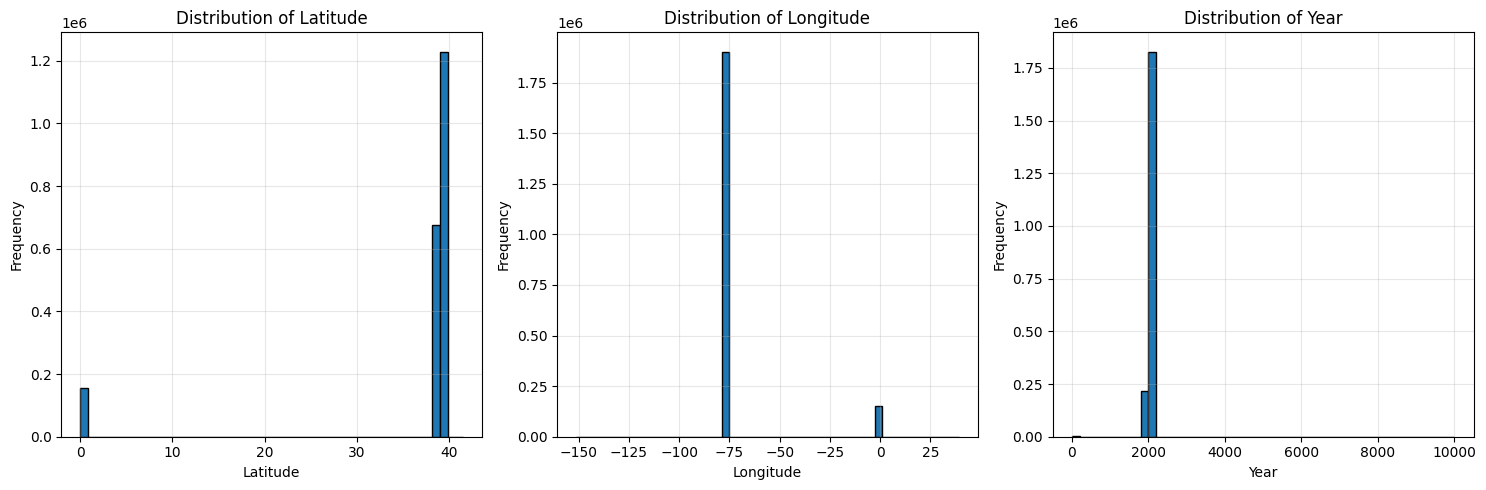


Numeric variables explored:
  - Latitude
  - Longitude
  - Year


In [ ]:
# ============================================================================
# 3.3.1.1: Numeric Variable Distributions
# ============================================================================
print_step_header("3.3.1.1", "Numeric Variable Distributions",
                  "Visualize distributions of numeric variables")
if numeric_cols:
    plot_distributions(df, numeric_cols, var_type='numeric')

## Exploration Conclusion: Numeric Variable Distributions

**Key Findings:**

1. **Geographic Concentration**: Data is concentrated in Maryland area (38-40°N, -75 to -70°W)
2. **Data Quality Issues**: 
   - ~150,000 cases with invalid coordinates (Latitude/Longitude near 0°)
   - ~250,000 cases with invalid vehicle years (Year 0-250)
3. **Temporal Trend**: Increasing violations from 2000-2020

**Next Steps:**

1. **Filter outliers**: Remove records with Latitude 0-5°, Longitude 0-10°, or Year < 1900
2. **Feature engineering**: Create vehicle age feature (current year - vehicle year)
3. **Geographic analysis**: Use valid coordinate range (38-40°N, -75 to -70°W) for spatial analysis



# STEP 3.3.1.2: Boolean Variable Distributions
# Explanation: Visualize distributions of boolean variables


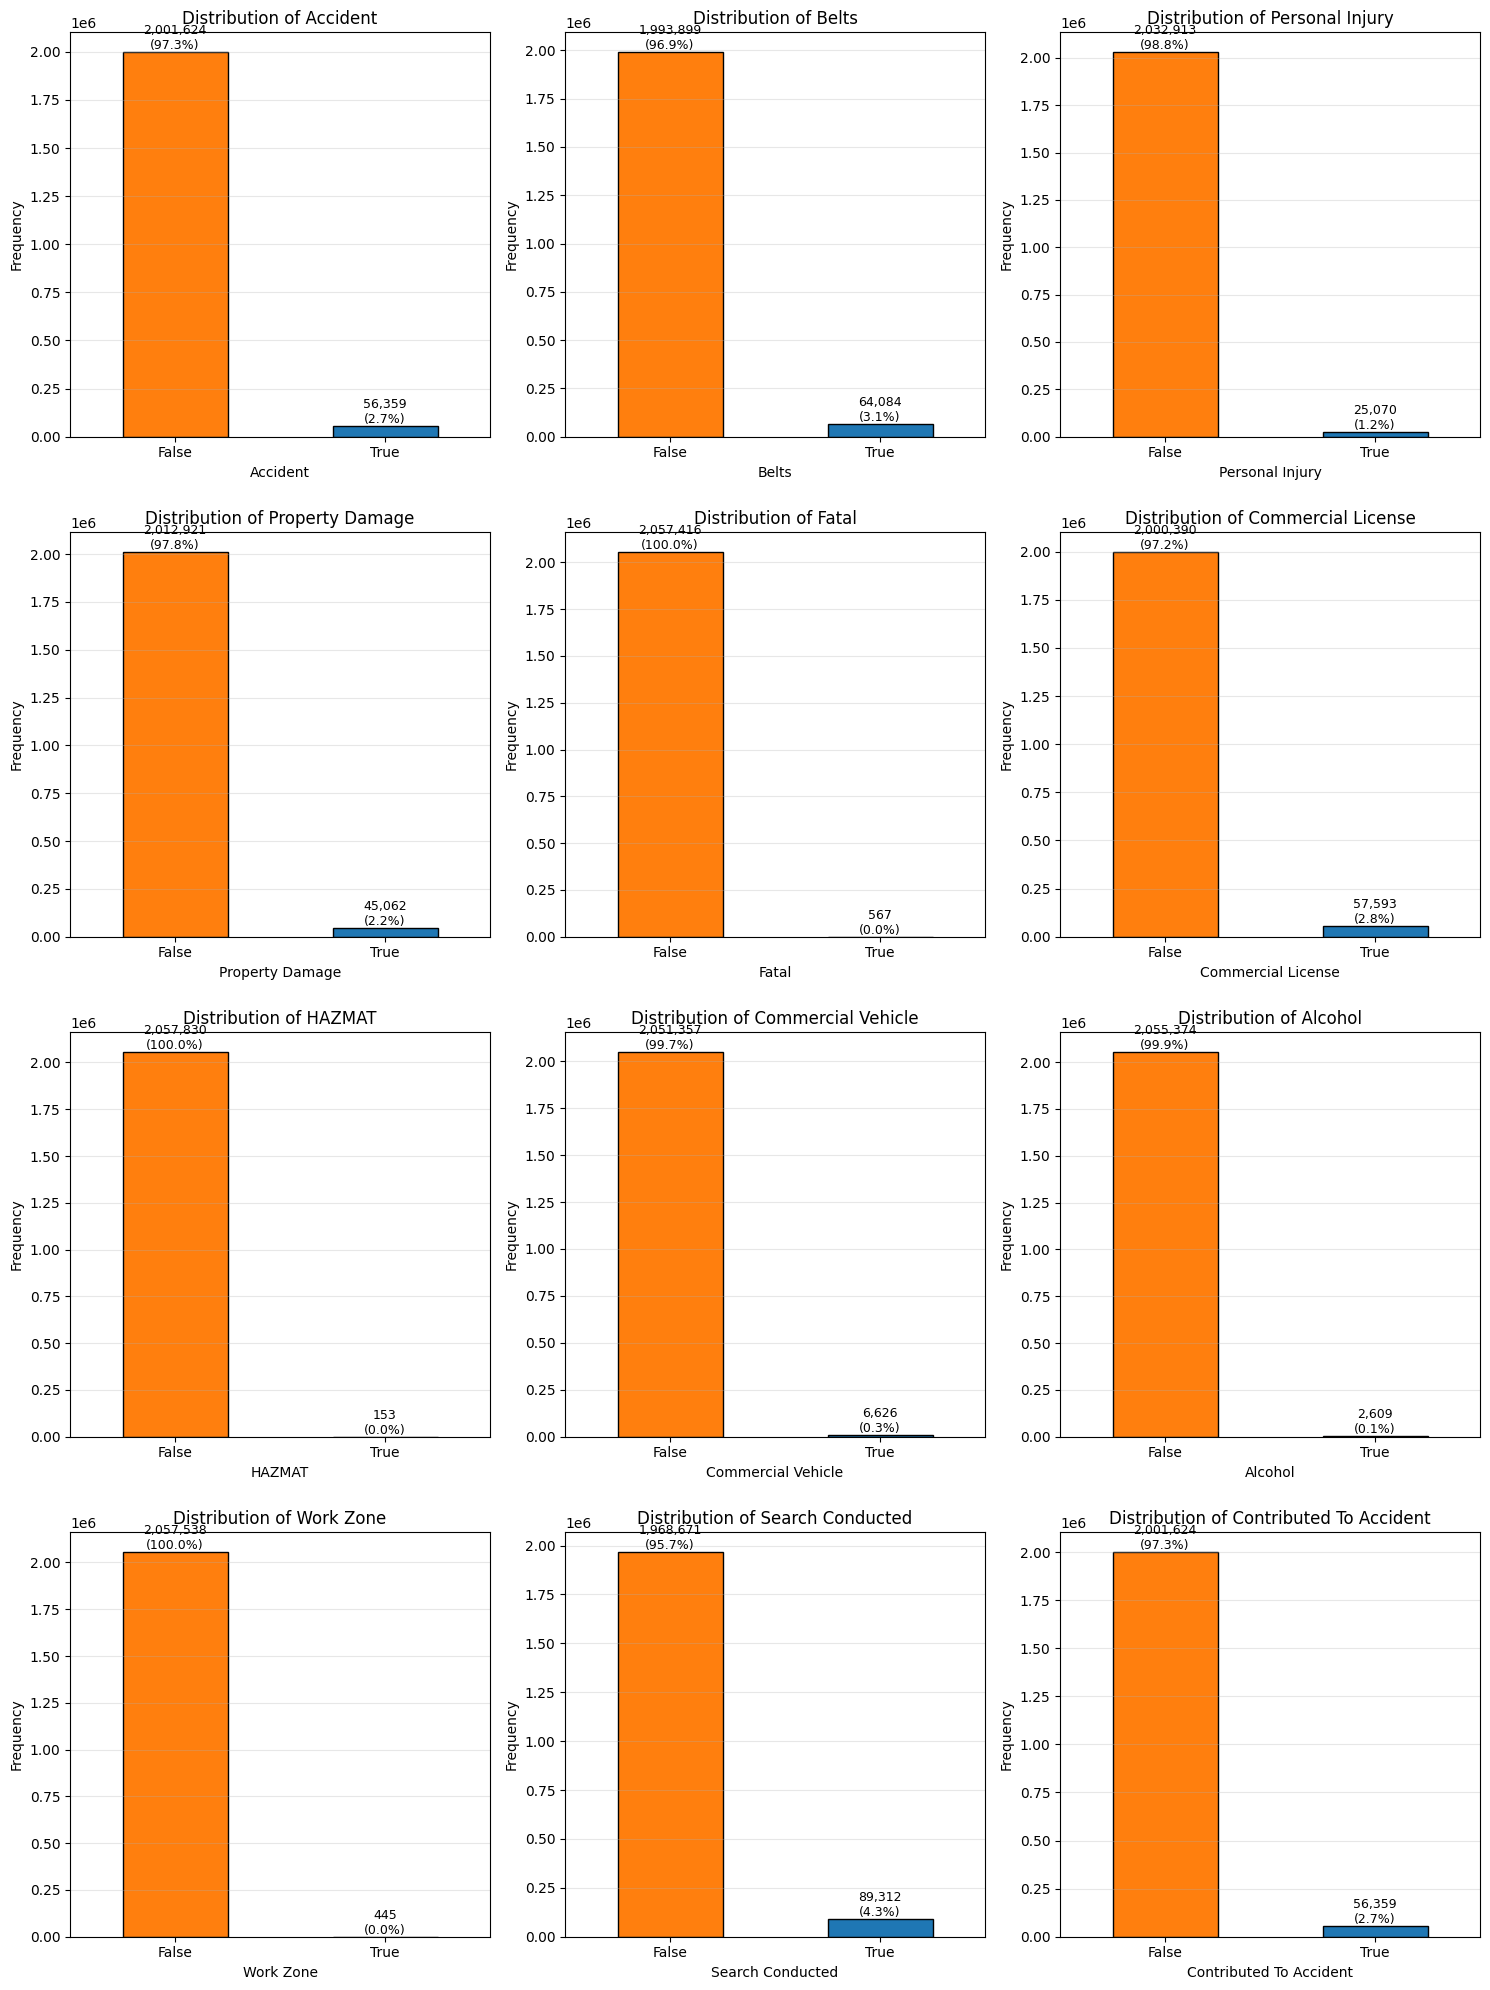

In [47]:
# ============================================================================
# 3.3.1.2: Boolean Variable Distributions
# ============================================================================
print_step_header("3.3.1.2", "Boolean Variable Distributions",
                  "Visualize distributions of boolean variables")
if bool_cols:
    plot_distributions(df, bool_cols, var_type='boolean')

## Exploration Conclusion: Boolean Variable Distributions

**Key Findings:**

1. **Extreme Class Imbalance**: Most boolean variables have >95% "False" values
2. **Rare Events**: Fatal (567 cases), HAZMAT (153 cases), Work Zone (445 cases) are extremely rare (<0.1%)
3. **Highest True Rate**: Search Conducted at 4.3% is the most balanced variable

**Next Steps:**

1. **Handle class imbalance**: Use class weighting or resampling techniques (SMOTE, undersampling)
2. **Evaluation metrics**: Use precision, recall, F1-score, ROC-AUC instead of accuracy
3. **Feature selection**: Consider excluding variables with <0.1% True rate or grouping rare categories
4. **Anomaly detection**: Consider anomaly detection approaches for rare event prediction



# STEP 3.3.1.3: Categorical Variable Distributions
# Explanation: Visualize distributions of categorical variables


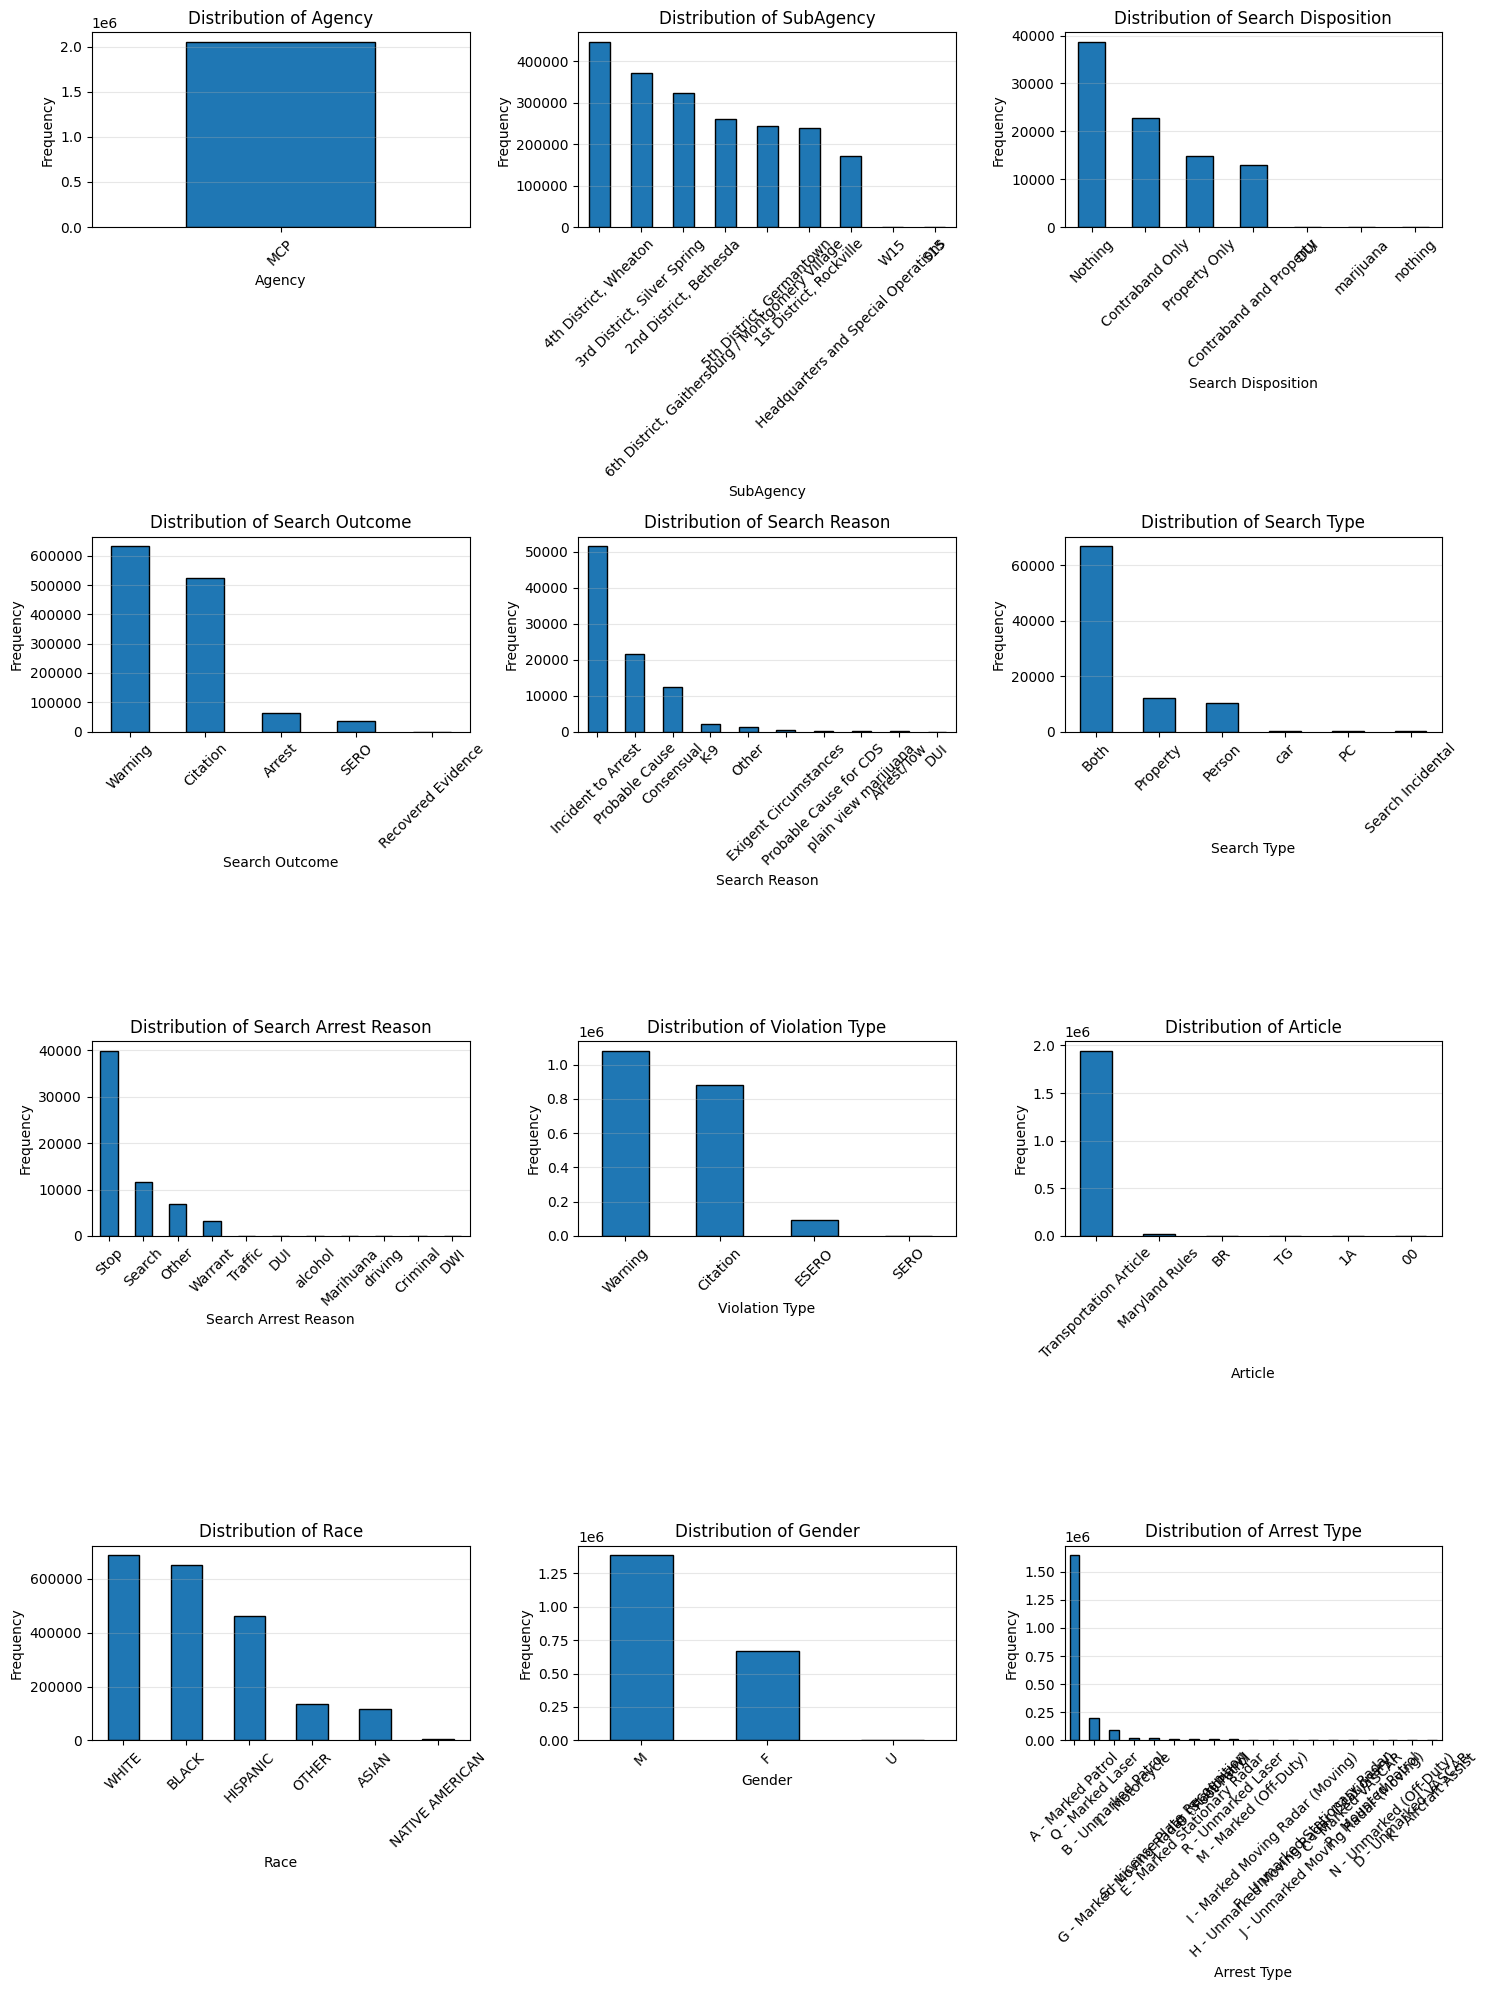


Categorical variables with low cardinality explored:

Agency:
  - Unique values: 1
  - Missing values: 0 (0.00%)
  - Top values:
    * MCP: 2,057,983 (100.0%)

SubAgency:
  - Unique values: 9
  - Missing values: 0 (0.00%)
  - Top values:
    * 4th District, Wheaton: 447,698 (21.8%)
    * 3rd District, Silver Spring: 372,089 (18.1%)
    * 2nd District, Bethesda: 323,290 (15.7%)
    * 6th District, Gaithersburg / Montgomery Village: 260,216 (12.6%)
    * 5th District, Germantown: 244,108 (11.9%)
    * 1st District, Rockville: 239,625 (11.6%)
    * Headquarters and Special Operations: 170,947 (8.3%)
    * W15: 7 (0.0%)
    * S15: 3 (0.0%)

Search Disposition:
  - Unique values: 7
  - Missing values: 1,968,671 (95.66%)
  - Top values:
    * Nothing: 38,752 (1.9%)
    * Contraband Only: 22,814 (1.1%)
    * Property Only: 14,763 (0.7%)
    * Contraband and Property: 12,964 (0.6%)
    * DUI: 12 (0.0%)
    * marijuana: 4 (0.0%)
    * nothing: 3 (0.0%)

Search Outcome:
  - Unique values: 5
  -

In [42]:
# ============================================================================
# 3.3.1.3: Categorical Variable Distributions
# ============================================================================
print_step_header("3.3.1.3", "Categorical Variable Distributions",
                  "Visualize distributions of categorical variables")
# Select key categorical columns for visualization (avoid high cardinality)
key_categorical_cols = []
for col in categorical_cols:
    unique_count = df[col].nunique()
    if unique_count <= 20:  # Only visualize categorical with reasonable cardinality
        key_categorical_cols.append(col)

if key_categorical_cols:
    plot_distributions(df, key_categorical_cols, var_type='categorical')
    print("\nCategorical variables with low cardinality explored:")
    for col in key_categorical_cols:
        print_categorical_summary(df, col)

# Summary statistics for high cardinality categorical columns
high_cardinality_cols = [col for col in categorical_cols if col not in key_categorical_cols]
if high_cardinality_cols:
    print("\nHigh cardinality categorical variables (summary only):")
    for col in high_cardinality_cols[:10]:  # Show first 10
        print_categorical_summary(df, col)


# STEP 3.3.2: Bivariate Analysis
# Explanation: Analyze relationships between pairs of variables

# STEP 3.3.2.1: Correlation Analysis
# Explanation: Correlation matrix for numeric variables


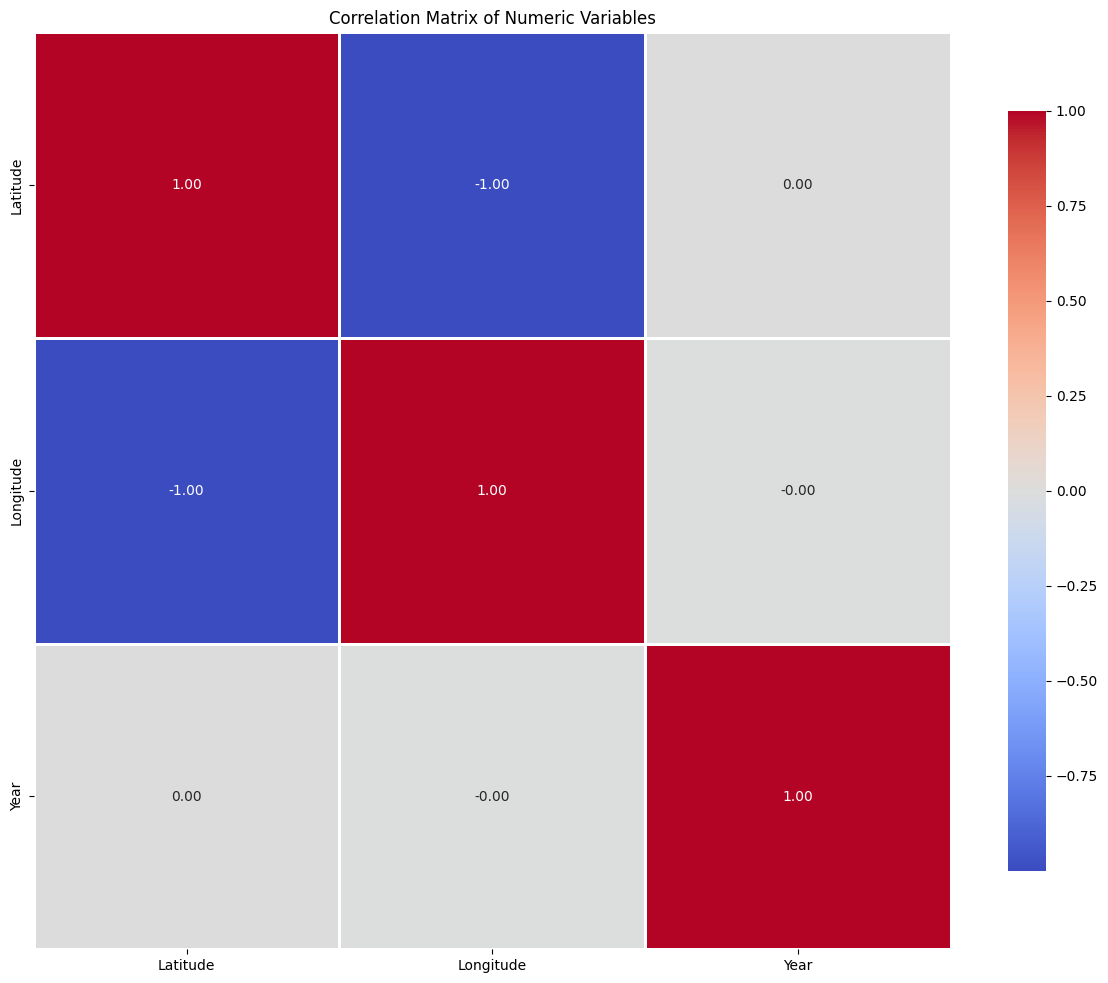


Strong correlations (|r| > 0.7):
  - Latitude <-> Longitude: -1.000


In [43]:
# ============================================================================
# 3.3.2: Bivariate Analysis
# ============================================================================
print_step_header("3.3.2", "Bivariate Analysis",
                  "Analyze relationships between pairs of variables")

# ============================================================================
# 3.3.2.1: Correlation Analysis for Numeric Variables
# ============================================================================
print_step_header("3.3.2.1", "Correlation Analysis",
                  "Correlation matrix for numeric variables")
if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.show()

    # Find strong correlations (absolute value > 0.7)
    print("\nStrong correlations (|r| > 0.7):")
    strong_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                strong_corr_pairs.append((correlation_matrix.columns[i],
                                         correlation_matrix.columns[j], corr_val))

    if strong_corr_pairs:
        for col1, col2, corr in strong_corr_pairs:
            print(f"  - {col1} <-> {col2}: {corr:.3f}")
    else:
        print("  - No strong correlations found (|r| > 0.7)")